In [1]:
# Importing Libraries

import os
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, ensemble, tree
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score,GridSearchCV,cross_validate
from sklearn.metrics import confusion_matrix, auc,roc_auc_score,roc_curve,recall_score,classification_report
import xgboost as xgb
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100, 'display.max_columns', 400)

# IMPORTING DATA

In [2]:
# Function to Load the file at specified path
# Parameters :- 1. path :- path from where file should be I

def Load_File(path) :
    if os.path.isfile(path) :
        data = pd.read_csv(path)
        data = data.replace('?', np.nan)
        print("\n" + "Number of rows in data are %s" % len(data))
        print("Number of columns in data are %s" % len(data.columns) + "\n")
        print("Following are the data types of columns:- ")
        print(data.dtypes)
        print("Number of missing values in the data are:- ")
        print(data.isnull().sum())
        print("Data Import is Complete")
        
        return data
    else:
        print(path + " does not exist. Enter the correct path")
        

# Generalized Function to plot the counts
# Parameters
# 1. rotx  : rotation of ticks on x-axis
# 2. roty  : rotation of ticks on y-axis
# 3. fontx : font size of ticks on x-axis
# 4. fonty : font size of ticks on y-axis
# 5. column_name : Name of the column for which we need the count
# 6. data_name   : Dataframe Used for plotting
# 7. plot_size   : Size of the plot
# 8. hue : If second column is needed for getting the count, the hue is True else False
# 9. hue_column_name = Second Column for plotting


def countplot(rotx, roty, fontx, fonty, column_name, data_name, plot_size = (10, 5), hue = False, hue_column_name=None):
    plt.figure(figsize = plot_size)
    plt.xticks(rotation=rotx, fontsize=fontx)
    plt.yticks(rotation=roty, fontsize=fonty)
    sns.set_style("whitegrid")
    if not hue:
        sns.countplot(column_name, data=data_name, palette='husl',
                      order = data_name[column_name].value_counts().index)
    else:
        sns.countplot(column_name, data=data_name, 
                      palette='husl', hue = hue_column_name,
                      order = data_name[column_name].value_counts().index)
    sns.despine()


# Function to Encode the Categorical Data Columns
# Parameters 1. df :- Dataframe 2. Column_name :- Feature to encode

def categorical_encoding(df, column_name_list=[]):
    
    for column_name in column_name_list:
        print(df[column_name].unique())
        categorical_columns = pd.get_dummies(df[column_name], prefix = column_name, 
                                             prefix_sep = '_', drop_first = False)
        df = pd.concat([df, categorical_columns], axis = 1)
        df = df.drop(column_name, axis = 1)
    return df


# Function to Label Encode the data
# Parameters :- 1. data :- Dataframe 2. columns_list :- List of columns to label encode

def labelEncoder(data, columns_list):
    for col in columns_list:
        encoder = LabelEncoder()
        data[col]  = encoder.fit_transform(data[col])
    return data


# Function to plot stacked plot
# Paramteres :- 
# data :- Dataframe used for plotting
# column_one :- Column One to group by
# column_two : Column Two to group by
# agg_column : Column to count numbers

def stacked_plot(data, column_one, column_two, agg_column, plot_size=(10, 5)):
    pal     = sns.color_palette("colorblind")
    grouped = data.groupby([column_one, column_two])[agg_column].count()
    grouped = grouped.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
    grouped = grouped.unstack(column_two).fillna(0)
    print(grouped)
    unique_list = list(data[column_two].unique())
    grouped[unique_list].plot(kind='bar', stacked=True, color=pal, figsize=plot_size)

Dari sini saya akan menambahkan komentar mengenai fitur-fitur yang ada pada satu tabel, penjelasan mengenai fiturnya bisa didapatkan melalui website resmi OULAD

In [3]:
# code_module          identification code of the module, to which the assessment belongs
# code_presentation    identification code of the presentation, to which the assessment belongs
# id_assessment        identification number of the assessment
# assessment_type      type of assessment
# date                 days information about the final submission date of the assessment calculated as the number of days 
#                      since the start of the module-presentation. The starting date of the presentation has number 0 (zero)
# weight               weight of the assessment in %. Typically, Exams are treated separately and have the weight 100%
#                      the sum of all other assessments is 100%

oulad_assessment = Load_File('assessments.csv')


Number of rows in data are 206
Number of columns in data are 6

Following are the data types of columns:- 
code_module           object
code_presentation     object
id_assessment          int64
assessment_type       object
date                 float64
weight               float64
dtype: object
Number of missing values in the data are:- 
code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64
Data Import is Complete


In [4]:
oulad_assessment.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


In [5]:
### Disini kita akan mengisi data kosong dengan mean tanggal yang ada pada tabel assesment pada kolom tanggal.

oulad_assessment['date'] = oulad_assessment['date'].fillna(int(oulad_assessment['date'].astype(float).mean()))

In [6]:
### Disini kita akan mencari ada berapa tipe modul

oulad_assessment['code_module'].unique()

array(['AAA', 'BBB', 'CCC', 'DDD', 'EEE', 'FFF', 'GGG'], dtype=object)

In [7]:
### Dan masing masing modul mempunyai 3 cara penilaian
# TMA :- Tutor Marked Assessment (Diberikan dosen)
# CMA :- Computer Marked Assessment (Diberikan sistem)
# Exam :- Final Exam

oulad_assessment['assessment_type'].unique()

array(['TMA', 'Exam', 'CMA'], dtype=object)

Histogram di bawah ini menunjukkan rentang (range) jumlah hari yang tersisa hingga batas waktu akhir pengumpulan suatu tugas atau proyek. Dalam konteks ini, histogram digunakan untuk memvisualisasikan sebaran atau distribusi berapa banyak hari yang tersisa hingga batas waktu akhir (misalnya, deadline) untuk pengumpulan suatu tugas atau proyek.

Histogram digunakan untuk melihat pola atau frekuensi berapa banyak tugas atau proyek yang memiliki berbagai jumlah hari tersisa hingga batas waktu akhir. Ini bisa membantu dalam memahami seberapa banyak tugas yang mungkin memiliki batas waktu yang mendekati atau melewati, atau seberapa banyak yang diselesaikan jauh sebelum batas waktu.

Dengan kata lain, histogram tersebut memberikan gambaran visual tentang bagaimana tugas-tugas atau proyek-proyek terdistribusi dalam hal jarak waktu yang tersisa hingga batas waktu akhirnya.

(array([29., 25., 22., 34., 20., 32., 44.]),
 array([ 12.        ,  47.57142857,  83.14285714, 118.71428571,
        154.28571429, 189.85714286, 225.42857143, 261.        ]),
 <BarContainer object of 7 artists>)

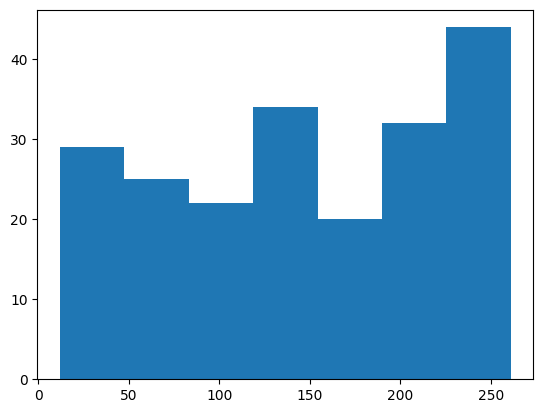

In [8]:
plt.hist(oulad_assessment['date'].astype(int), bins=7)

In [9]:
# code_module         name of the module, which serves as the identifier
# code_presentation   name of the presentation. It consists of the year and B for the presentation 
#                     starting in February and J for the presentation starting in October
# length              length of the module presentation in days

oulad_courses = Load_File('courses.csv')


Number of rows in data are 22
Number of columns in data are 3

Following are the data types of columns:- 
code_module                   object
code_presentation             object
module_presentation_length     int64
dtype: object
Number of missing values in the data are:- 
code_module                   0
code_presentation             0
module_presentation_length    0
dtype: int64
Data Import is Complete


In [10]:
oulad_courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


In [11]:
# id_assessment            the identification number of the assessment
# id_student               a unique identification number for the student
# date_submitted           the date of student submission, measured as the number of days 
#.                         since the start of the module presentation
# is_banked                a status flag indicating that the assessment result has been transferred from a previous presentation
# score                    the studentís score in this assessment. The range is from 0 to 100. The score lower than 40 is 
#                          interpreted as Fail. The marks are in the range from 0 to 100

oulad_student_assessment = Load_File('studentAssessment.csv')


Number of rows in data are 173912
Number of columns in data are 5

Following are the data types of columns:- 
id_assessment       int64
id_student          int64
date_submitted      int64
is_banked           int64
score             float64
dtype: object
Number of missing values in the data are:- 
id_assessment       0
id_student          0
date_submitted      0
is_banked           0
score             173
dtype: int64
Data Import is Complete


In [12]:
### Disini akan kita drop nilai yang kosong, mengapa? Karena data yang hilang sangat sedikit (insignifikan) 
### dibandingkan total datanya

oulad_student_assessment = oulad_student_assessment.dropna()

In [13]:
oulad_student_assessment.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [14]:
# code_module             an identification code for a module
# code_presentation       the identification code of the presentation
# id_student              a unique identification number for the student
# date_registration       the date of student's registration on the module presentation, this is the number of days measured relative to 
#                         the start of the module-presentation (e.g. the negative value -30 means that the student registered to module
#                         presentation 30 days before it started)
# date_unregistration     date of student unregistration from the module presentation, this is the number of days measured relative to 
#                         the start of the module-presentation. Students, who completed the course have this field empty. Students who 
#                         unregistered have Withdrawal as the value of the final_result column in the studentInfo.csv file

oulad_student_registration = Load_File('studentRegistration.csv')


Number of rows in data are 32593
Number of columns in data are 5

Following are the data types of columns:- 
code_module             object
code_presentation       object
id_student               int64
date_registration      float64
date_unregistration    float64
dtype: object
Number of missing values in the data are:- 
code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64
Data Import is Complete


In [15]:
## Dari deskripsi di atas maka bisa dilihat banyak sekali missing value pada kolom date_unreg
## jika tidak ada missing value maka dikatakan siswa telah menyelesaikan course sedangkan jika kosong dikatakan 'withdrawn'

## 0 : 'COMPLETED'
## 1 : 'WITHDRAWN'

## Karena sedikit sekali missing value pada kolom date_reg maka akan diisi dengan 0 begitu pula yang ada di kolom date_unreg
## sedangkan kolom date unregistration akan ditandai dengan 1 jika data tidak null

oulad_student_registration['date_unregistration'] = ['0' if pd.isnull(days) else '1' for days in oulad_student_registration['date_unregistration']]
oulad_student_registration['date_registration']   = oulad_student_registration['date_registration'].fillna(0).astype(float).apply(abs)


In [16]:
oulad_student_registration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,159.0,0
1,AAA,2013J,28400,53.0,0
2,AAA,2013J,30268,92.0,1
3,AAA,2013J,31604,52.0,0
4,AAA,2013J,32885,176.0,0


In [17]:
"""Loading Student Information Data"""

# code_module             an identification code for a module on which the student is registered
# code_presentation       the identification code of the presentation during which the student is registered on the module
# id_student              a unique identification number for the student
# gender                  the studentís gender
# region                  identifies the geographic region, where the student lived while taking the module-presentation
# highest_education       highest student education level on entry to the module presentation
# imd_band                specifies the Index of Multiple Depravation band of the place where the student lived during the module-presentation
# age_band                band of the studentís age
# num_of_prev_attempts    the number times the student has attempted this module
# studied_credits         the total number of credits for the modules the student is currently studying
# disability              indicates whether the student has declared a disability
# final_result            studentís final result in the module-presentation

oulad_student_info = Load_File('studentInfo.csv')


Number of rows in data are 32593
Number of columns in data are 12

Following are the data types of columns:- 
code_module             object
code_presentation       object
id_student               int64
gender                  object
region                  object
highest_education       object
imd_band                object
age_band                object
num_of_prev_attempts     int64
studied_credits          int64
disability              object
final_result            object
dtype: object
Number of missing values in the data are:- 
code_module                0
code_presentation          0
id_student                 0
gender                     0
region                     0
highest_education          0
imd_band                1111
age_band                   0
num_of_prev_attempts       0
studied_credits            0
disability                 0
final_result               0
dtype: int64
Data Import is Complete


Ada nilai yang hilang (missing values) dalam kolom "imd_band." Kolom ini berisi informasi tentang kategori atau kelompok tertentu yang berkaitan dengan suatu data. Misalnya, "imd_band" bisa mengacu pada kelompok tingkat kekayaan atau indeks deprivasi.

Untuk mengatasi nilai yang hilang dalam kolom "imd_band," maka saya mengisi nilai-nilai yang hilang dengan nilai yang paling sering muncul dalam kolom tersebut. Nilai yang paling sering muncul ini disebut "mode." Pendekatan ini akan mengisi nilai-nilai yang hilang dengan kategori yang paling umum atau paling sering muncul dalam data, sehingga memungkinkan data tersebut untuk tetap digunakan dalam analisis atau pemodelan lebih lanjut tanpa menghilangkan baris dengan nilai yang hilang.

In [18]:
print(oulad_student_info['imd_band'].unique())

oulad_student_info['imd_band'] = oulad_student_info['imd_band'].fillna(oulad_student_info['imd_band'].mode()[0])

['90-100%' '20-30%' '30-40%' '50-60%' '80-90%' '70-80%' nan '60-70%'
 '40-50%' '10-20' '0-10%']


In [19]:
oulad_student_info.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [20]:
# code_module           an identification code for a module
# code_presentation     the identification code of the module presentation
# id_student            a unique identification number for the student
# id_site               an identification number for the VLE material
# date                  the date of studentís interaction with the material measured as the 
#                       number of days since the start of the module-presentation
# sum_click             the number of times a student interacts with the material in that day 

oulad_student_vle = Load_File('studentVle.csv')


Number of rows in data are 10655280
Number of columns in data are 6

Following are the data types of columns:- 
code_module          object
code_presentation    object
id_student            int64
id_site               int64
date                  int64
sum_click             int64
dtype: object
Number of missing values in the data are:- 
code_module          0
code_presentation    0
id_student           0
id_site              0
date                 0
sum_click            0
dtype: int64
Data Import is Complete


In [21]:
oulad_student_vle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


In [22]:
# id_site              an identification number of the material
# code_module          an identification code for module
# code_presentation    the identification code of presentation
# activity_type        the role associated with the module material
# week_from            the week from which the material is planned to be used
# week_to              week until which the material is planned to be used

oulad_vle = Load_File('vle.csv')


Number of rows in data are 6364
Number of columns in data are 6

Following are the data types of columns:- 
id_site                int64
code_module           object
code_presentation     object
activity_type         object
week_from            float64
week_to              float64
dtype: object
Number of missing values in the data are:- 
id_site                 0
code_module             0
code_presentation       0
activity_type           0
week_from            5243
week_to              5243
dtype: int64
Data Import is Complete


In [23]:
### Karena ada hampir 100% data yang hilang pada kolom week_from dan week_to maka kita drop saja kolomnya

oulad_vle = oulad_vle.drop(['week_from', 'week_to'], axis = 1)

In [24]:
oulad_vle.head()

,id_site,code_module,code_presentation,activity_type
0,546943,AAA,2013J,resource
1,546712,AAA,2013J,oucontent
2,546998,AAA,2013J,resource
3,546888,AAA,2013J,url
4,547035,AAA,2013J,resource


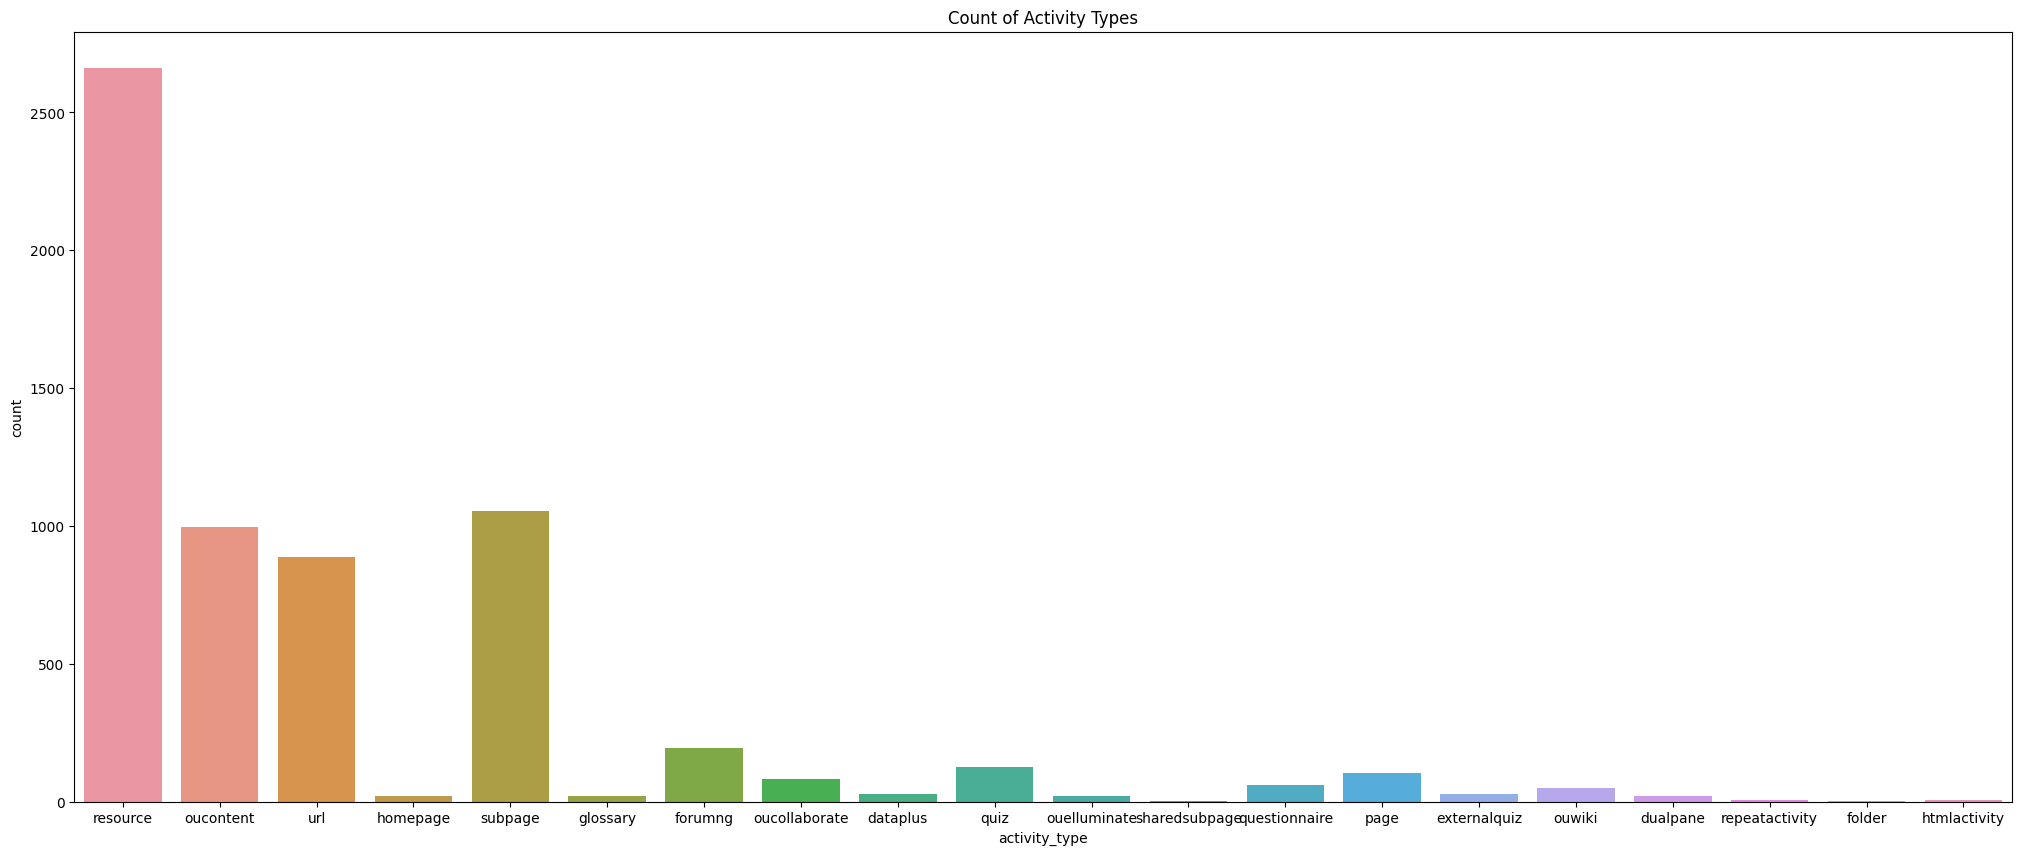

In [25]:
### Dari sini kita bisa melihat bahwa tipe aktivitas paling banyak pada LMS adalah 'Resources'

# Set ukuran plot
plt.figure(figsize=(25, 10))

# Membuat countplot
sns.countplot(data=oulad_vle, x='activity_type')

# Menambahkan judul
plt.title('Count of Activity Types')

# Menampilkan plot
plt.show()

# INTEGRASI DATA

#### Disini kita akan mulai Integrasi Data berdasarkan tabel yang ada pada website OULAD

Database schema.png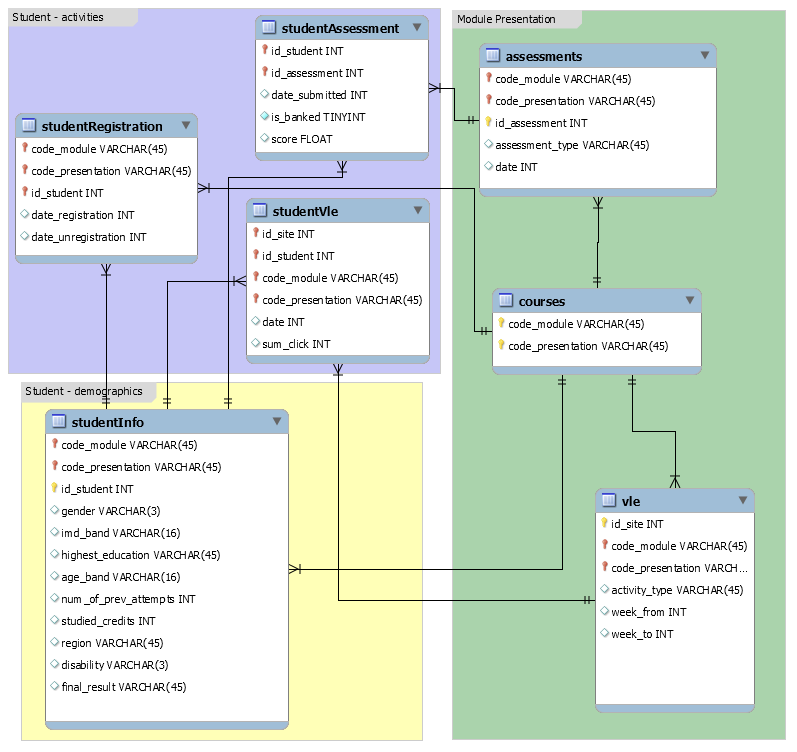

### Langkah pertama kita bisa gabungkan tabel student vle dan vle. Dari sini seharusnya kita bisa melihat interaksi siswa dengan LMS.

In [26]:
student_vle_merge_vle = oulad_student_vle.merge(oulad_vle, 
                                                on=['id_site', 'code_module', 'code_presentation'],
                                                how = 'left')

Dari merge tabel di bawah bisa dilihat bahwa tabel menggambarkan bahwa dalam data atau studi yang sedang dilakukan, terlihat bahwa ada banyak interaksi yang dilakukan oleh seorang siswa sebelum kursus dimulai. Dalam konteks ini, "interaksi" merujuk pada aktivitas atau keterlibatan siswa dalam bahan atau materi kursus sebelum kursus tersebut secara resmi dimulai.

Pernyataan tersebut kemudian mengusulkan dua hal:

Asumsi tentang Minat Siswa: Asumsi dibuat bahwa jika seorang siswa tertarik dalam kursus tersebut, maka mereka akan berinteraksi dengan materi kursus sebelum kursus dimulai. Dengan kata lain, siswa yang aktif berinteraksi dengan materi sebelum kursus dimulai kemungkinan besar memiliki minat yang tinggi dalam kursus tersebut.

Jumlah Klik Sebelum dan Setelah Kursus Dimulai: Untuk mengukur minat dan keterlibatan siswa, jumlah klik (interaksi) yang dilakukan oleh siswa sebelum dan setelah kursus dimulai akan dihitung. Ini akan memberikan informasi tentang seberapa aktif siswa dalam memeriksa materi sebelum kursus dimulai (misalnya, materi prakursus atau informasi kursus pra-awal) dan seberapa aktif mereka selama kursus berlangsung.

Dengan mengamati jumlah klik sebelum dan setelah kursus dimulai, penelitian atau analisis ini berusaha untuk menentukan apakah ada korelasi antara tingkat keterlibatan awal siswa dengan hasil akhir atau kinerja mereka dalam kursus. Dalam beberapa konteks, tingkat keterlibatan awal dapat digunakan sebagai faktor penting untuk memprediksi apakah seorang siswa akan berhasil atau tidak dalam kursus tersebut.

In [27]:
student_vle_merge_vle[(student_vle_merge_vle['id_student']==28400) & (student_vle_merge_vle['date']<0)].head(10)

,code_module,code_presentation,id_student,id_site,date,sum_click,activity_type
0,AAA,2013J,28400,546652,-10,4,forumng
1,AAA,2013J,28400,546652,-10,1,forumng
2,AAA,2013J,28400,546652,-10,1,forumng
3,AAA,2013J,28400,546614,-10,11,homepage
4,AAA,2013J,28400,546714,-10,1,oucontent
5,AAA,2013J,28400,546652,-10,8,forumng
6,AAA,2013J,28400,546876,-10,2,subpage
7,AAA,2013J,28400,546688,-10,15,oucontent
8,AAA,2013J,28400,546662,-10,17,oucontent
9,AAA,2013J,28400,546890,-10,1,url


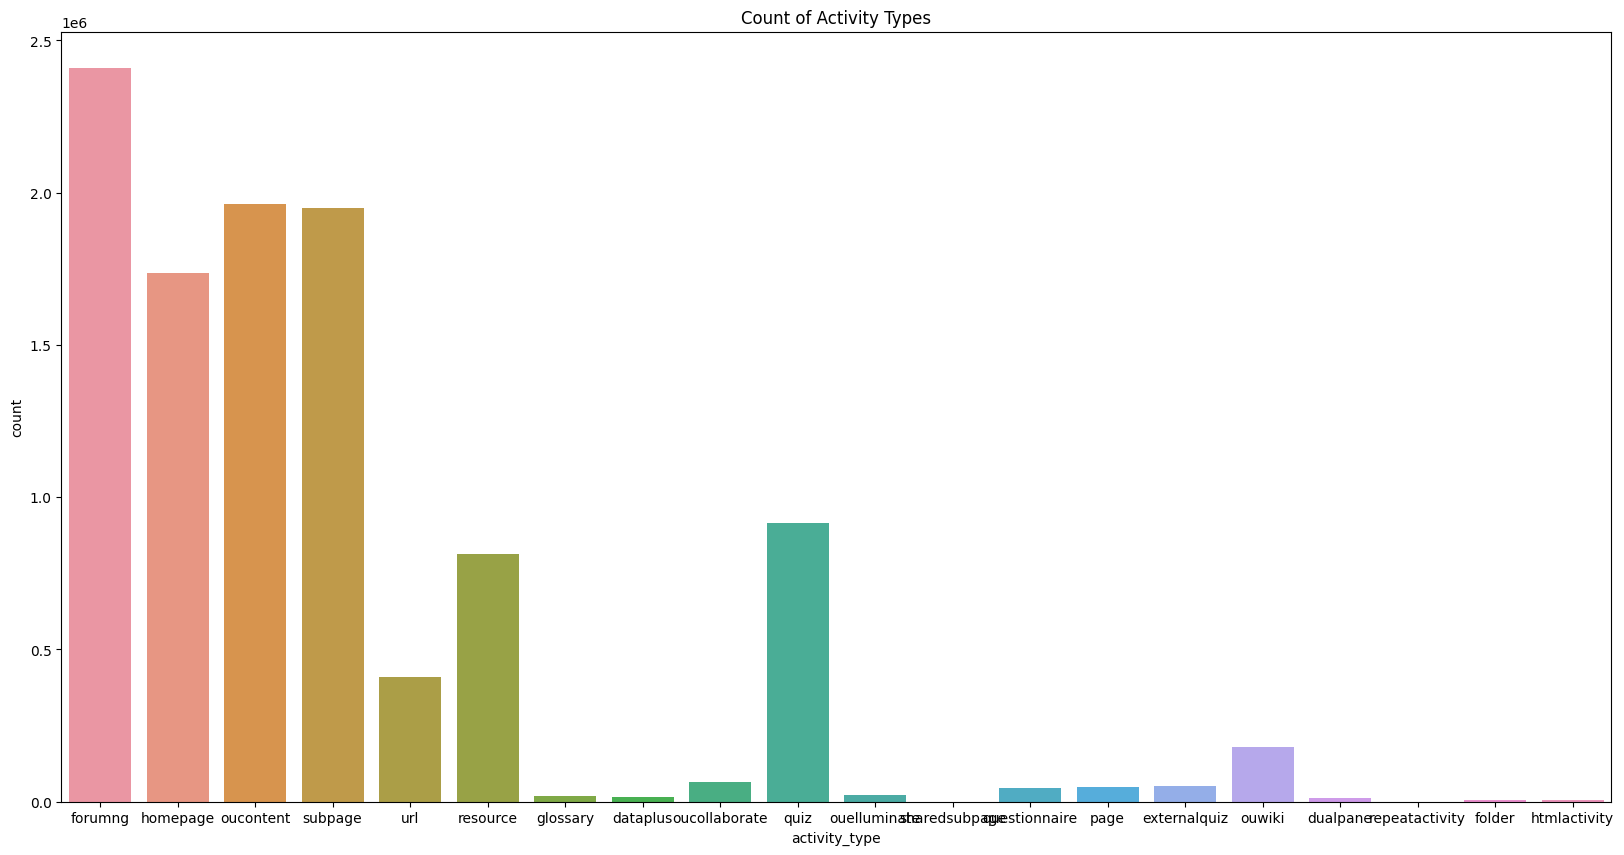

In [28]:
### Plot dibawah akan memperlihatkan cara apa yang digunakan siswa untuk mengakses VLE
### Kita bisa lihat bahwa paling banyak melalui ForumNG (Open University Forum Platform),
### oucontent (Open University Content), subpage dan homepage.

# Set ukuran plot
plt.figure(figsize=(20, 10))

# Membuat countplot
sns.countplot(data=student_vle_merge_vle, x='activity_type')

# Menambahkan judul
plt.title('Count of Activity Types')

# Menampilkan plot
plt.show()

<Axes: xlabel='activity_type'>

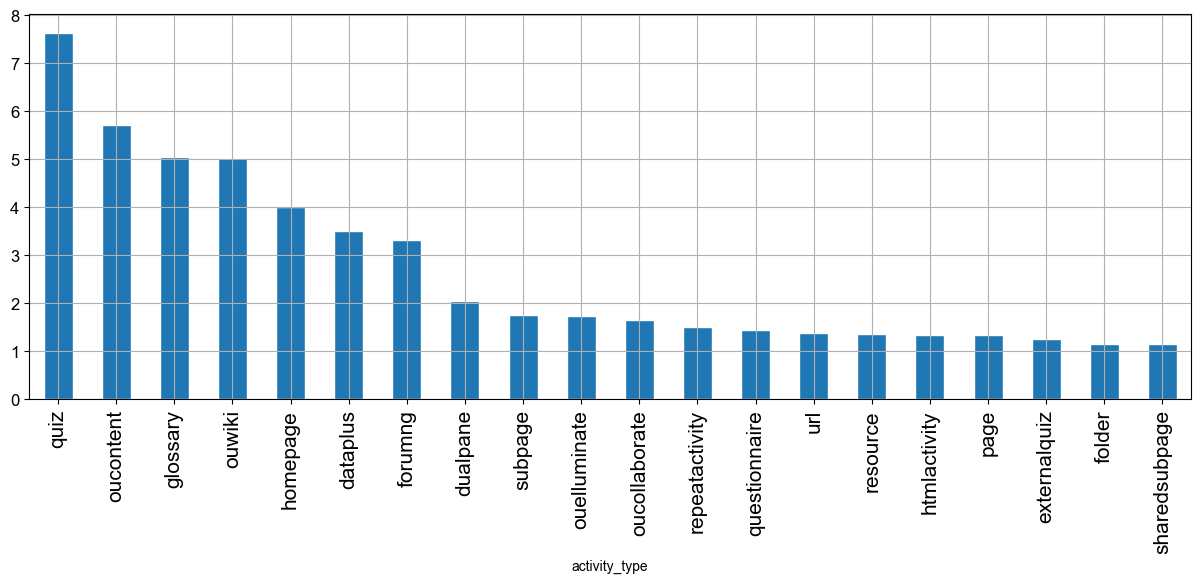

In [29]:
plt.figure(figsize = (15, 5))
plt.xticks(rotation=90, fontsize=15)
plt.yticks(rotation=0, fontsize=12)
sns.set_style("whitegrid")
student_vle_merge_vle.groupby(['activity_type'], as_index=True)['sum_click'].mean().sort_values(ascending=False).plot(kind='bar')


Plot tersebut menggambarkan rata-rata interaksi siswa dengan setiap jenis aktivitas atau tipe aktivitas yang tersedia dalam data. Plot ini bertujuan untuk memberikan pemahaman tentang seberapa sering siswa berinteraksi dengan berbagai jenis aktivitas dalam lingkungan pembelajaran online atau platform pembelajaran.

Berikut adalah penjelasan satu per satu:

Interaksi dengan QUIZ: Pada plot, terlihat bahwa ada tingkat interaksi yang tinggi dengan jenis aktivitas "QUIZ." Ini bisa dimengerti karena siswa umumnya berinteraksi dengan kuis setelah belajar sesuatu. Kuis dapat digunakan untuk menguji pemahaman siswa terhadap materi yang baru dipelajari.

Interaksi dengan OUCONTENT: Terlihat bahwa aktivitas "OUCONTENT" juga memiliki tingkat interaksi yang tinggi. Ini bisa dimengerti karena siswa sering berinteraksi dengan konten atau materi pembelajaran untuk memahami materi yang diajarkan.

Interaksi dengan GLOSSARY: Aktivitas "GLOSSARY" juga memiliki tingkat interaksi yang tinggi. Ini menunjukkan bahwa siswa sering menggunakan glosarium untuk memahami istilah atau kata-kata kunci dalam materi pembelajaran. Glosarium dapat membantu mereka memahami dengan lebih baik apa yang diajarkan.

Interaksi dengan OUWIKI: Aktivitas "OUWIKI" juga menunjukkan tingkat interaksi yang tinggi. Ini mungkin karena siswa menggunakan wiki untuk mendapatkan informasi tambahan atau mendalam tentang topik tertentu.

Secara keseluruhan, plot ini membantu dalam memahami pola interaksi siswa dengan berbagai jenis aktivitas dalam lingkungan pembelajaran online, dan interpretasi tersebut memberikan beberapa pemahaman tentang bagaimana siswa memanfaatkan sumber daya pembelajaran yang tersedia untuk mereka.

In [30]:
student_vle_merge_vle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click,activity_type
0,AAA,2013J,28400,546652,-10,4,forumng
1,AAA,2013J,28400,546652,-10,1,forumng
2,AAA,2013J,28400,546652,-10,1,forumng
3,AAA,2013J,28400,546614,-10,11,homepage
4,AAA,2013J,28400,546714,-10,1,oucontent


###### Disini kita coba merge tabel studentRegistration dengan tabel courses untuk mengetahuin korelasi antara registrasi dan panjang course(durasinya)

In [31]:
student_registration_merge_courses = oulad_student_registration.merge(oulad_courses, 
                                                                      on = ['code_module', 'code_presentation'],
                                                                      how = 'left')

In [32]:
student_registration_merge_courses['Year'] = student_registration_merge_courses['code_presentation'].str[0:4]
student_registration_merge_courses['Starting_Month'] = ['February' if code[-1] == 'B' else 'October' 
                                                        for code in student_registration_merge_courses['code_presentation']]

In [33]:
student_registration_merge_courses

,code_module,code_presentation,id_student,date_registration,date_unregistration,module_presentation_length,Year,Starting_Month
0,AAA,2013J,11391,159.0,0,268,2013,October
1,AAA,2013J,28400,53.0,0,268,2013,October
2,AAA,2013J,30268,92.0,1,268,2013,October
3,AAA,2013J,31604,52.0,0,268,2013,October
4,AAA,2013J,32885,176.0,0,268,2013,October
...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,4.0,0,269,2014,October
32589,GGG,2014J,2645731,23.0,0,269,2014,October
32590,GGG,2014J,2648187,129.0,0,269,2014,October
32591,GGG,2014J,2679821,49.0,1,269,2014,October


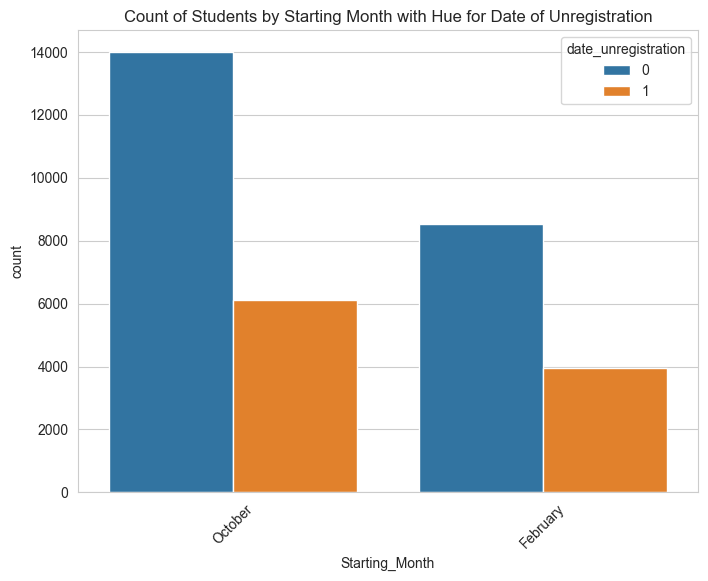

In [34]:
# Plot ini menggambarkan bahwa di bulan oktober adalah bulan paling banyak siswa melakuka registrasi dan pengunduran diri
# Set ukuran plot
plt.figure(figsize=(8, 6))

# Membuat countplot
sns.countplot(data=student_registration_merge_courses, x='Starting_Month', hue='date_unregistration')

# Menambahkan judul
plt.title('Count of Students by Starting Month with Hue for Date of Unregistration')

# Menampilkan plot
plt.xticks(rotation=45)
plt.show()


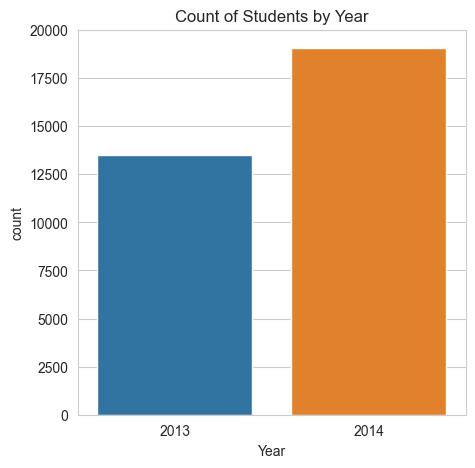

In [35]:
### Tahun 2014 terjadi peningkatan pada jumlah siswa yang mendaftar

# Set ukuran plot
plt.figure(figsize=(5, 5))

# Membuat countplot
sns.countplot(data=student_registration_merge_courses, x='Year')

# Menambahkan judul
plt.title('Count of Students by Year')

# Menampilkan plot
plt.show()

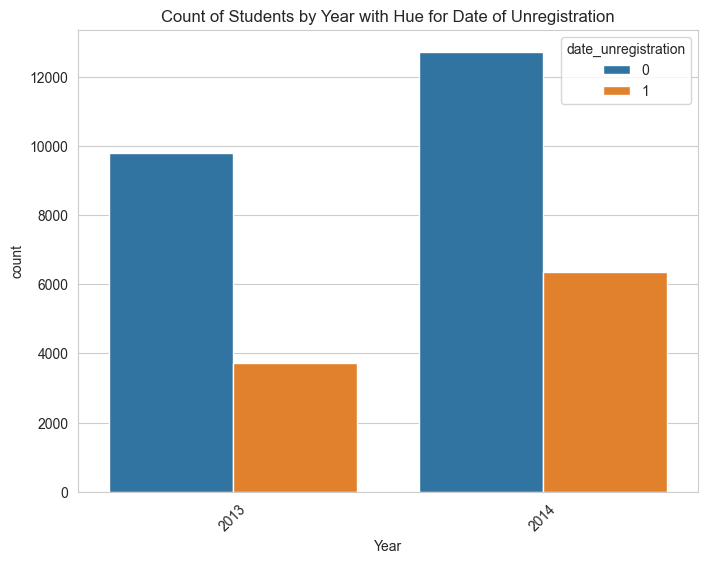

In [36]:
# Dan di tahun 2014 juga banyak yang menyelesaikan coursenya

# Set ukuran plot
plt.figure(figsize=(8, 6))

# Membuat countplot dengan hue
sns.countplot(data=student_registration_merge_courses, x='Year', hue='date_unregistration')

# Menambahkan judul
plt.title('Count of Students by Year with Hue for Date of Unregistration')

# Menampilkan plot
plt.xticks(rotation=45)
plt.show()



In [37]:
# terlihat bahwa tidak ada perbedaan yang signifikan dalam durasi atau panjang kursus antara siswa yang menarik diri (withdrawn)
# dan siswa yang menyelesaikan (completed) kursus pada tabel di bawah ini.

student_registration_merge_courses.groupby('date_unregistration', as_index=False)['module_presentation_length'].mean()

,date_unregistration,module_presentation_length
0,0,256.095378
1,1,255.819500


###### Sekarang waktunya integrasi antara merge assessments Table dan studentAssessment Table untuk mengetahui korelasi antara assesment dan student performance

In [38]:
student_assessment_merge_assessment = oulad_student_assessment.merge(oulad_assessment,
                                                                     on = ['id_assessment'], how='left' )

In [39]:
student_assessment_merge_assessment.dtypes

id_assessment          int64
id_student             int64
date_submitted         int64
is_banked              int64
score                float64
code_module           object
code_presentation     object
assessment_type       object
date                 float64
weight               float64
dtype: object

Code di bawah ini akan mengevaluasi apakah mahasiswa telah mengumpulkan tugas mereka terlambat atau tepat waktu berdasarkan dua kolom dalam data, yaitu "date_submitted" (hari setelah mahasiswa menerima tugas mereka) dan "date" (batas waktu pengumpulan dalam hari untuk tugas tersebut). Setelah evaluasi ini, kita akan menentukan apakah pengumpulan tugas tersebut terlambat atau tepat waktu, dengan menggunakan label 0 untuk tugas yang terlambat dan label 1 untuk tugas yang tepat waktu.

Jadi, ini adalah langkah untuk mengkategorikan pengumpulan tugas mahasiswa dalam dua kategori, yakni "terlambat" atau "tepat waktu," berdasarkan perbandingan antara tanggal pengumpulan dan batas waktu yang telah ditentukan

In [40]:
student_assessment_merge_assessment['Late_submission'] = ['0' if int(student_assessment_merge_assessment['date_submitted'].iloc[i]) 
                                                          > int(student_assessment_merge_assessment['date'].iloc[i]) else '1' 
                                                         for i in range(len(student_assessment_merge_assessment))]


In [41]:
print('Persentase Mahasiswa yang terlambat mengumpulkan: ')
print((len(student_assessment_merge_assessment[student_assessment_merge_assessment['Late_submission']=='0'])/len(student_assessment_merge_assessment)*100))

Persentase Mahasiswa yang terlambat mengumpulkan: 
29.958155624240963


Late_submission                          0          1
assessment_type assessment_type                      
CMA             CMA              46.777830  53.222170
Exam            Exam             57.914902  42.085098
TMA             TMA              16.473797  83.526203


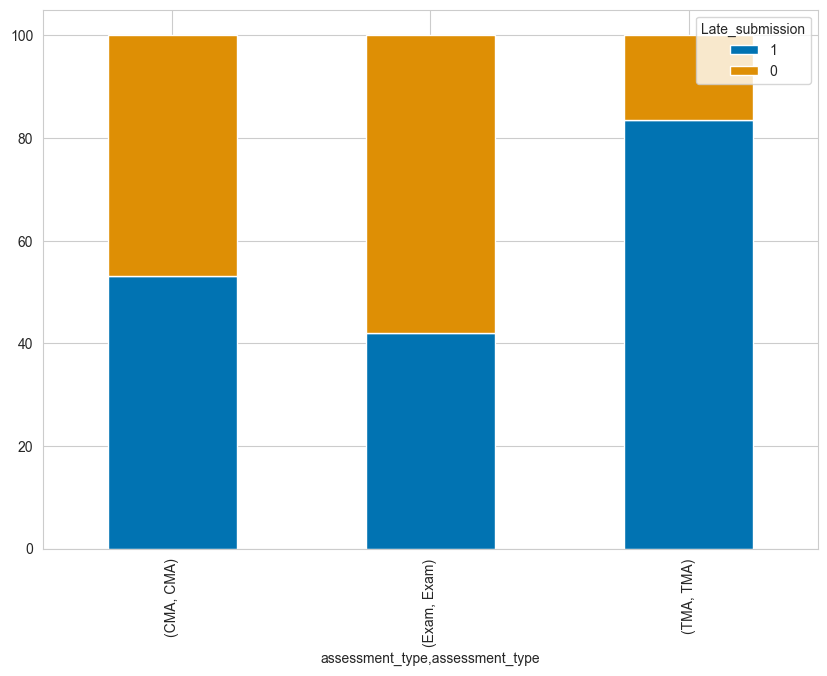

In [42]:
# Ada 3 tipe penilaian di dalam modul :- Tutor Marked Assessment (TMA/Dosen), Computer Marked Assessment (CMA), Exams
# Plot di bawah akan menunjukkan berapa banyak keterlambatan pengumpulan berdasarkan tipe penilaian

stacked_plot(student_assessment_merge_assessment, 'assessment_type', 'Late_submission', 'id_student', plot_size=(10, 7))



Plot di atas menunjukkan bahwa keterlambatan pengumpulan banyak ditemui pada CMA dan Exam

Late_submission                  0          1
code_module code_module                      
AAA         AAA          25.810553  74.189447
BBB         BBB          47.472021  52.527979
CCC         CCC          69.063342  30.936658
DDD         DDD          30.566283  69.433717
EEE         EEE          14.544763  85.455237
FFF         FFF          10.345268  89.654732
GGG         GGG          10.049293  89.950707


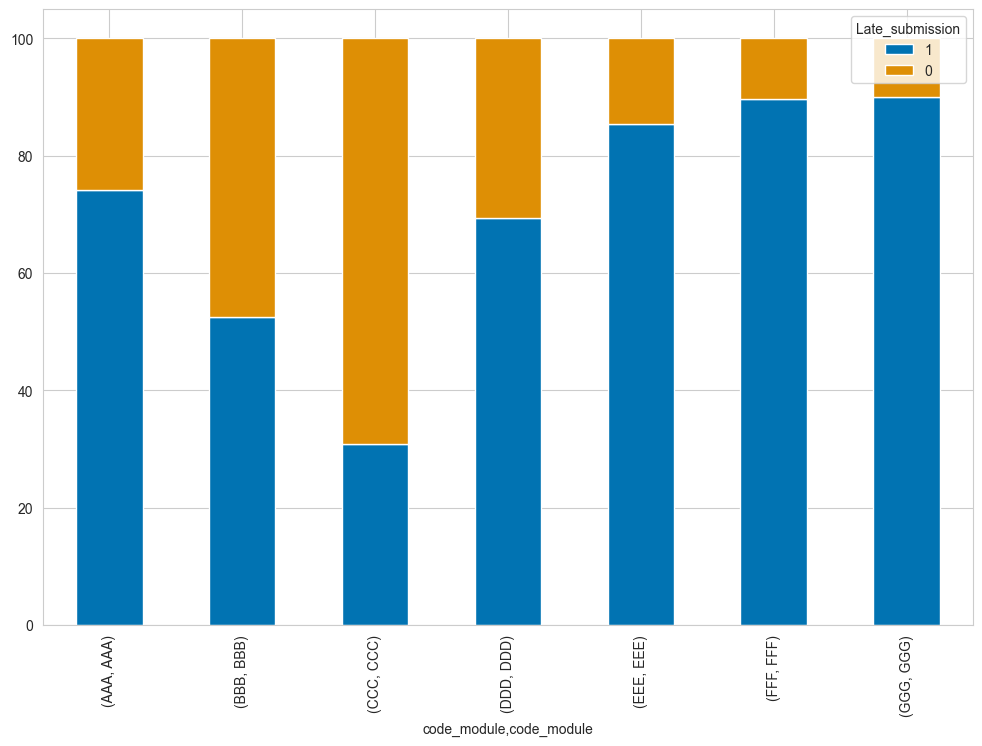

In [43]:
# Dataset mempunyai 7 code module. 4 modul untuk STEM dan 3 untuk Social Sciences
# Social Sciences :- AAA, BBB, GGG
# STEM :- CCC, DDD, EEE, FFF
# Dapat dilihat dari plot di bawah ini bahwa keterlambatan pengumpulan banyak terjadi di Course BBB, CCC dan DDD


stacked_plot(student_assessment_merge_assessment, 'code_module', 'Late_submission', 'id_student', plot_size=(12, 8))

In [44]:
## Dalam assesment terdapat bobot penilaian dan dari bobot tersebut dapat mempengaruhi hasil akhir siswa. 
## Disini akan saya buat 3 kategori bobot pada penilaian assesment yang ada

print(student_assessment_merge_assessment['weight'].unique())

percentage_segment = []

for percent in student_assessment_merge_assessment['weight']:
    if percent <= 10:
        percentage_segment.append('Low_Weightage')
    elif percent > 10 and percent <= 30:
        percentage_segment.append('Medium_Weightage')
    else:
        percentage_segment.append('High_Weightage')
        
student_assessment_merge_assessment['Weigthage'] = percentage_segment

[ 10.   20.   30.    5.   18.    1.    0.   35.    9.   22.    2.    7.
   8.  100.    7.5  12.5  15.    3.    4.    6.   17.5  25.   16.   28. ]


Maka bisa terlihat dari plot diatas bahwasanya siswa yang mengumpulkan terlambat  mempunyai rasio gagal yang lebih tinggi walaupun persentasi lulusnya juga tinggi

In [45]:
student_assessment_merge_assessment.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,Late_submission,Weigthage
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0,1,Low_Weightage
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0,0,Low_Weightage
2,1752,31604,17,0,72.0,AAA,2013J,TMA,19.0,10.0,1,Low_Weightage
3,1752,32885,26,0,69.0,AAA,2013J,TMA,19.0,10.0,0,Low_Weightage
4,1752,38053,19,0,79.0,AAA,2013J,TMA,19.0,10.0,1,Low_Weightage


###### Integrasi VLE DATA Dengan STUDENT INFO DATA

In [46]:
student_info = oulad_student_info.merge(student_vle_merge_vle, 
                                        on = ['code_module', 'code_presentation', 'id_student'],
                                        how = 'left')

In [47]:
student_info['highest_education'].unique()

array(['HE Qualification', 'A Level or Equivalent', 'Lower Than A Level',
       'Post Graduate Qualification', 'No Formal quals'], dtype=object)

###### Integrasi Student Info dengan Student Registration

In [48]:
student_registration_merge_courses = student_registration_merge_courses.drop('date_unregistration', axis = 1)

In [49]:
student_info = student_info.merge(student_registration_merge_courses,
                                 on = ['code_module', 'code_presentation', 'id_student'],
                                 how = 'left')

In [50]:
student_info['num_of_prev_attempts'] = [0 if attempts == 0 else 1 for attempts in student_info['num_of_prev_attempts']]

# DATA PREPARATION
#### Feature Selection
#### Data Encoding
#### Splitting Data

In [51]:
student_info['date_registration'] = student_info['date_registration'].astype(float)

In [52]:
student_info['date_registration'].describe()

count    1.065864e+07
mean     6.931983e+01
std      4.764116e+01
min      0.000000e+00
25%      2.900000e+01
50%      5.700000e+01
75%      9.900000e+01
max      3.220000e+02
Name: date_registration, dtype: float64

In [53]:
student_info.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,id_site,date,sum_click,activity_type,date_registration,module_presentation_length,Year,Starting_Month
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,546669.0,-5.0,16.0,oucontent,159.0,268,2013,October
1,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,546662.0,-5.0,44.0,oucontent,159.0,268,2013,October
2,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,546652.0,-5.0,1.0,forumng,159.0,268,2013,October
3,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,546668.0,-5.0,2.0,oucontent,159.0,268,2013,October
4,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,546652.0,-5.0,1.0,forumng,159.0,268,2013,October


In [ ]:
student_info.to_csv('OULADBIAS.csv', index=False)